In [1]:
from __future__ import print_function
import sys
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5
import matplotlib.pyplot as plt
%matplotlib notebook
import gvar as gv
import fkfpi_lib as flib
print("python version:", sys.version)
print("pandas version:", pd.__version__)
print("numpy  version:", np.__version__)
print("gvar   version:", gv.__version__)

python version: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
pandas version: 0.20.1
numpy  version: 1.12.1
gvar   version: 8.3.2


In [2]:
switches = dict()
switches['ensemble'] = [
    'a15m310','a12m310','a09m310',
    'a15m220','a12m220','a09m220','a12m220S','a12m220L',
    'a12m130']
    #'a15m130','a12m130']
switches['ansatz'] = dict()
switches['ansatz']['FV'] = True # True turns on NLO FV correction
switches['ansatz']['type'] = 'MA' # Type of fit: 'xpt' or 'MA'
switches['ansatz']['a2dm'] = 'individual' # avg or individual
switches['scale'] = 'PK' # PP, PK, KK, LamChi = 4 * pi * sqrt(FA * FB)

In [3]:
# Set priors for Xpt
priors = dict()
priors['L5'] = gv.gvar(0.0, 1.0)
priors['s4'] = gv.gvar(0.0, 1.0)
priors['c4'] = gv.gvar(0.0, 1.0)
priors['d4'] = gv.gvar(0.0, 1.0)
priors['e4'] = gv.gvar(0.0, 1.0)
# Physical parameters from PDG
phys_p = dict()
# http://pdg.lbl.gov/2016/tables/rpp2016-tab-mesons-light.pdf
phys_p['mpi'] = gv.gvar(134.8, 0.3) #FLAG 2017 (16)
phys_p['mka'] = gv.gvar(494.2 , 0.3) #FLAG 2017 (16)
phys_p['F0'] = gv.gvar(80,20) #FLAG use of F0 in SU(2) correction for FK/Fpi
phys_p['meta'] = gv.gvar(547.862,0.017) #PDG
# http://pdg.lbl.gov/2015/reviews/rpp2015-rev-pseudoscalar-meson-decay-cons.pdf
phys_p['Fpi'] = gv.gvar(130.2/np.sqrt(2), 1.7/np.sqrt(2)) #PDG fpi+ eq(16)
phys_p['Fka'] = gv.gvar(155.6/np.sqrt(2), 0.4/np.sqrt(2)) #PDG fK++ eq(16)
if switches['scale'] == 'PK':
    phys_p['Lchi'] = 4*np.pi*np.sqrt(phys_p['Fpi']*phys_p['Fka'])
elif switches['scale'] == 'PP':
    phys_p['Lchi'] = 4*np.pi*phys_p['Fpi']
elif switches['scale'] == 'KK':
    phys_p['Lchi'] = 4*np.pi*phys_p['Fka']
# FLAG FK/Fpi
flag_FKFpi = gv.gvar(1.1933, 0.0029)

In [4]:
data = pd.read_csv('./github_fkfpi_v1.csv')
hisq_params = pd.read_csv('./hisq_params.csv')
mixed_params = pd.read_csv('./github_mixed_v1.csv')

In [5]:
fmt_data = flib.format_data(switches,data,mixed_params,hisq_params,priors)
#print(fmt_data)

In [6]:
fit = flib.fit_data(switches,fmt_data,phys_p)
print(fit.format(maxline=True,pstyle='m'))

Least Square Fit:
  chi2/dof [dof] = 0.81 [9]    Q = 0.61    logGBF = 26.945

Parameters:
             L5    0.00017 (30)      [     0.0 (1.0) ]  
             s4      0.091 (30)      [     0.0 (1.0) ]  
             c4      -0.20 (78)      [     0.0 (1.0) ]  
             d4       0.28 (96)      [     0.0 (1.0) ]  
             e4       0.48 (68)      [     0.0 (1.0) ]  
          mpi 0    0.23610 (29)      [  0.23609 (29) ]  
              1    0.18868 (22)      [  0.18862 (23) ]  
              2    0.14070 (12)      [  0.14074 (12) ]  
              4    0.13426 (17)      [  0.13427 (17) ]  
              5   0.097897 (63)      [ 0.097896 (63) ]  
              6    0.13560 (32)      [  0.13556 (32) ]  
              7    0.13403 (15)      [  0.13402 (15) ]  
              8    0.08120 (23)      [  0.08128 (24) ]  
          mka 0    0.40453 (25)      [  0.40460 (25) ]  
              1    0.32426 (19)      [  0.32416 (21) ]  
              2    0.24102 (13)      [  0.24110 (14) ] 

<IPython.core.display.Javascript object>


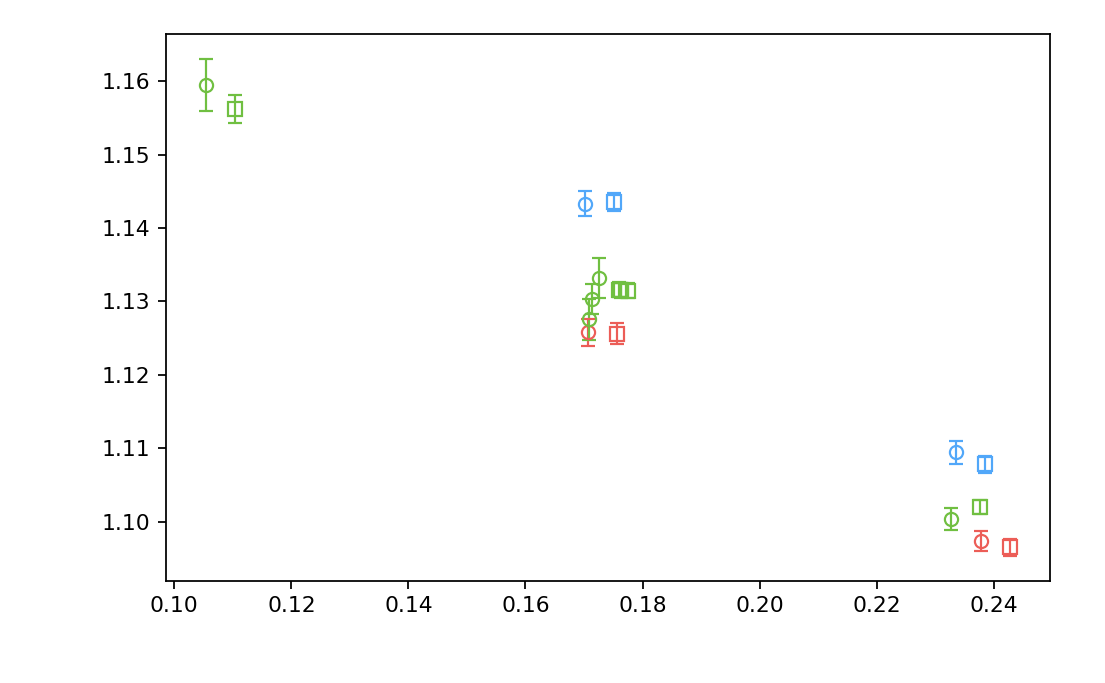

 a15m310 1.0973(14) 1.0965(12)
 a12m310 1.1004(15) 1.10202(95)
 a09m310 1.1094(16) 1.1078(12)
 a15m220 1.1258(18) 1.1256(14)
 a12m220 1.1303(21) 1.1315(10)
 a09m220 1.1434(17) 1.1436(13)
a12m220S 1.1332(27) 1.1315(10)
a12m220L 1.1276(28) 1.1316(11)
 a12m130 1.1595(35) 1.1563(19)


In [7]:
fig = plt.figure('FK/Fpi',figsize=(7,4.326237))
ax = plt.axes([0.15,0.15,0.8,0.8])
colors ={'a15m310':'#ec5d57','a15m220':'#ec5d57','a15m130':'#ec5d57',
        'a12m310':'#70bf41','a12m220':'#70bf41','a12m130':'#70bf41','a12m220S':'#70bf41','a12m220L':'#70bf41',
        'a09m310':'#51a7f9','a09m220':'#51a7f9'}
for i,e in enumerate(switches['ensemble']):
    epi = fmt_data['p']['mpi'][i]/fmt_data['x']['Lchi'][i]
    print('%8s %s %s' %(e,str(fmt_data['y'][i]),str(fit.fcn(fit.x,fit.p)[i])))
    ax.errorbar(epi.mean,fmt_data['y'][i].mean,yerr=fmt_data['y'][i].sdev,color=colors[e],marker='o',elinewidth=1,capsize=3,mfc='none')
    ax.errorbar(epi.mean+.005,fit.fcn(fit.x,fit.p)[i].mean,yerr=fit.fcn(fit.x,fit.p)[i].sdev,color=colors[e],marker='s',elinewidth=1,capsize=3,mfc='none')
plt.savefig('FKFpi_vs_epi.pdf',transparent=True)

In [8]:
print(flib.fkfpi_phys(phys_p,fit))

prediction from LQCD
FK / Fpi =  1.176(27)
FK+/Fpi+ =  1.174(26)
prediction from LQCD + meta_PDG
FK / Fpi =  1.173(27)
FK+/Fpi+ =  1.171(26)
None
